# Ames Housing Data model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('datasets/train.csv', index_col = 'PID')
kaggle_test = pd.read_csv('datasets/test.csv', index_col = 'PID')

In [3]:
df.shape, kaggle_test.shape

((2051, 80), (878, 79))

In [4]:
np.sqrt(2051)

45.28796749689701

# Purpose:

The primary purpose of this exercise is to develop a regression model that accurately predicts home values for homes at sale in the Ames Iowa Housing dataset consistent with the Kaggle Rules- https://www.kaggle.com/c/dsi-us-12-project-2-regression-challenge.

By definition this will be looking at linear regression, lasso and ridge models with the goal of getting the Root Mean Squared Error (RMSE) as close to 0 as possible for the test data provided on Kaggle.

## Data Cleaning and Feature Engineering Per EDA

In [5]:
df.drop(df[df['Gr Liv Area'] > 4000].index, inplace = True)  
# jse.amstat.org recommends dropping any homes with greater 'GR Liv Area' greater than 4k sqft
# as they are outliers.

In [6]:
df = pd.get_dummies(df, columns = ["Neighborhood",
                                   "Roof Style",
                                   'Mas Vnr Type'],
                    drop_first= True)

In [7]:
explanatory_vars = df.drop(columns = ['BsmtFin SF 1', 'Screen Porch',
                                      'Enclosed Porch', 'Kitchen AbvGr', 'Lot Frontage',
                                      'Id', 'Overall Cond', 'Mas Vnr Area',
                                      'Paved Drive', 'Sale Type', 'MS Zoning', 
                                      'Functional', 'Heating QC', 'House Style', 
                                      'Lot Frontage', 'MS SubClass', 'Bsmt Half Bath',
                                      'Low Qual Fin SF', 'Yr Sold', 'Misc Val', 
                                      'BsmtFin SF 2', 'Pool Area', 'Mo Sold', '3Ssn Porch', 
                                      'Bedroom AbvGr', 'Bsmt Unf SF', '2nd Flr SF',
                                      'Half Bath', 'Bsmt Full Bath', "Lot Area",
                                      'Wood Deck SF', 'Open Porch SF', 'Street',
                                      'Alley', 'Lot Shape', 'Land Contour',
                                       'Utilities', 'Lot Config', 'Land Slope',
                                      'Condition 1', 'Condition 2', 'Garage Cars',
                                      'Bldg Type', 'House Style', 
                                      'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
                                      'Exter Qual', 'Exter Cond',
                                      'Foundation', 'Bsmt Qual', 'Bsmt Cond',
                                      'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2',
                                      'Heating', 'Electrical', 'Kitchen Qual', 
                                      "Fireplace Qu", 'Garage Type', 'Garage Finish',
                                      'Garage Qual', 'Garage Cond', 'Paved Drive',
                                      'Pool QC', 'Fence', 'Misc Feature', 
                                      'Central Air', 'Garage Yr Blt',
                                      'Neighborhood_Landmrk', 'Neighborhood_GrnHill',
                                     ]).columns

In [8]:
model = df[explanatory_vars].copy()
# in this case I am assuming the value of Garage area and Garage Cars being unknown to mean no garage and therefore 0.

I discovered in EDA that where Masonry Veneer Type is np.nan, the masonry veneer area is 0. AKA No masonry. Similar for . Filling NA's with 0 to capture 'no masonry veneer, or no basement' as 0.

In [9]:
model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 533352170 to 527162130
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Overall Qual          2049 non-null   int64  
 1   Year Built            2049 non-null   int64  
 2   Year Remod/Add        2049 non-null   int64  
 3   Total Bsmt SF         2048 non-null   float64
 4   1st Flr SF            2049 non-null   int64  
 5   Gr Liv Area           2049 non-null   int64  
 6   Full Bath             2049 non-null   int64  
 7   TotRms AbvGrd         2049 non-null   int64  
 8   Fireplaces            2049 non-null   int64  
 9   Garage Area           2048 non-null   float64
 10  SalePrice             2049 non-null   int64  
 11  Neighborhood_Blueste  2049 non-null   uint8  
 12  Neighborhood_BrDale   2049 non-null   uint8  
 13  Neighborhood_BrkSide  2049 non-null   uint8  
 14  Neighborhood_ClearCr  2049 non-null   uint8  
 15  Neighbor

In [10]:
model.fillna(0, inplace = True)

In [11]:
model.shape

(2049, 44)

__Feature Engineering__

In [12]:
# there's a lot of factors in this set that are likely to be collinear.  
# used answer at https://stackoverflow.com/questions/48223443/how-to-run-a-multicollinearity-test-on-a-pandas-dataframe
# to determine correct funciton is through statsmodel 
# statsmodel variance_inflation_factor documentation refers to:
# https://en.wikipedia.org/wiki/Variance_inflation_factor 
# and indicates a VIF of 5 or higher is considered oversized.

In [13]:
variables = list(range(model.shape[1]))

columns = pd.Series(model.columns, name = 'Col_name')
vif = pd.Series([variance_inflation_factor(model.iloc[:, variables].values, ix) for ix in variables], name = 'VIF')
vif_df = pd.concat([columns, vif], axis = 1)
vif_df = vif_df.sort_values('VIF', ascending = False)
# Using a DataFrame to organize and better display VIF data inspired by 
# Mahdi Shadkam-Farrokhi's Quiz 02 review.
vif_df.head(10) 
# the two biggest VIF scores are Year Remod/Add and Year Built.
# This tells me that year remodeled and year built are directly connected and
# I only want to include one of the two in my model.  Removing Year Remod/Add

,Col_name,VIF
2,Year Remod/Add,13174.437764
1,Year Built,12958.542020
36,Roof Style_Gable,138.006790
0,Overall Qual,72.785667
5,Gr Liv Area,69.148078
7,TotRms AbvGrd,60.860584
10,SalePrice,43.746937
4,1st Flr SF,38.417036
42,Mas Vnr Type_None,37.273774
38,Roof Style_Hip,34.215328


In [14]:
model.head(3)

,Overall Qual,Year Built,Year Remod/Add,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Area,...,Neighborhood_Timber,Neighborhood_Veenker,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone
PID,,,,,,,,,,,,,,,,,,,,,
533352170,6,1976,2005,725.0,725,1479,2,6,0,475.0,...,0,0,1,0,0,0,0,1,0,0
531379050,7,1996,1997,913.0,913,2122,2,8,1,559.0,...,0,0,1,0,0,0,0,1,0,0
535304180,5,1953,2007,1057.0,1057,1057,1,5,0,246.0,...,0,0,1,0,0,0,0,0,1,0


## Train-Test-Split

In [15]:
X = model.drop(columns = 'SalePrice')
y = np.log(model['SalePrice'])

In [16]:
ss = StandardScaler()
ss.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [18]:
Z_train = ss.transform(X_train)

In [19]:
Z_test = ss.transform(X_test)

## Model

##### Linear Regression Model

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.8864239818851668, 0.8533616232909382)

In [22]:
cross_val_score(lr, X_train, y_train).mean()

0.875955920135401

## Evaluate Model

In [23]:
y_test_preds = np.exp(lr.predict(X_test))

In [24]:
rmse = mean_squared_error(np.exp(y_test), y_test_preds) ** 0.5
rmse

23297.733901688513

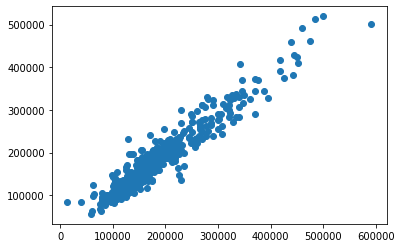

In [25]:
plt.scatter(np.exp(y_test), y_test_preds)

In [26]:
test_residuals = y_test_preds - np.exp(y_test)

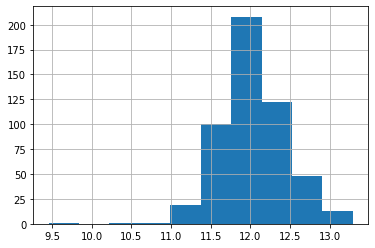

In [27]:
y_test.hist()

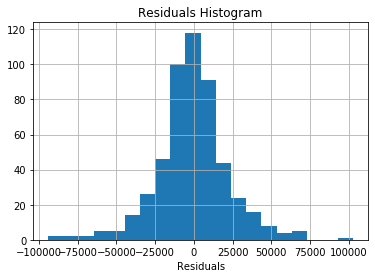

In [28]:
test_residuals.hist(bins = 20)
plt.xlabel('Residuals')
plt.title('Residuals Histogram');

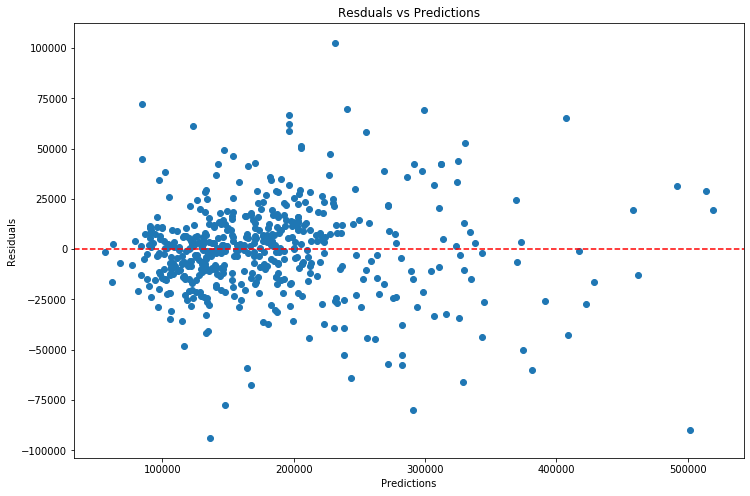

In [29]:
plt.figure(figsize = (12, 8))
plt.scatter(y_test_preds, test_residuals)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.axhline(c = 'red', ls = 'dashed')
plt.title('Resduals vs Predictions');

In [30]:
columns = pd.Series(X.columns, name = "col_name")
coefs   = pd.Series(lr.coef_, name = "coef")
coef_df = pd.concat([columns, coefs], axis = 1)
coef_df = coef_df.sort_values('coef', ascending = False)

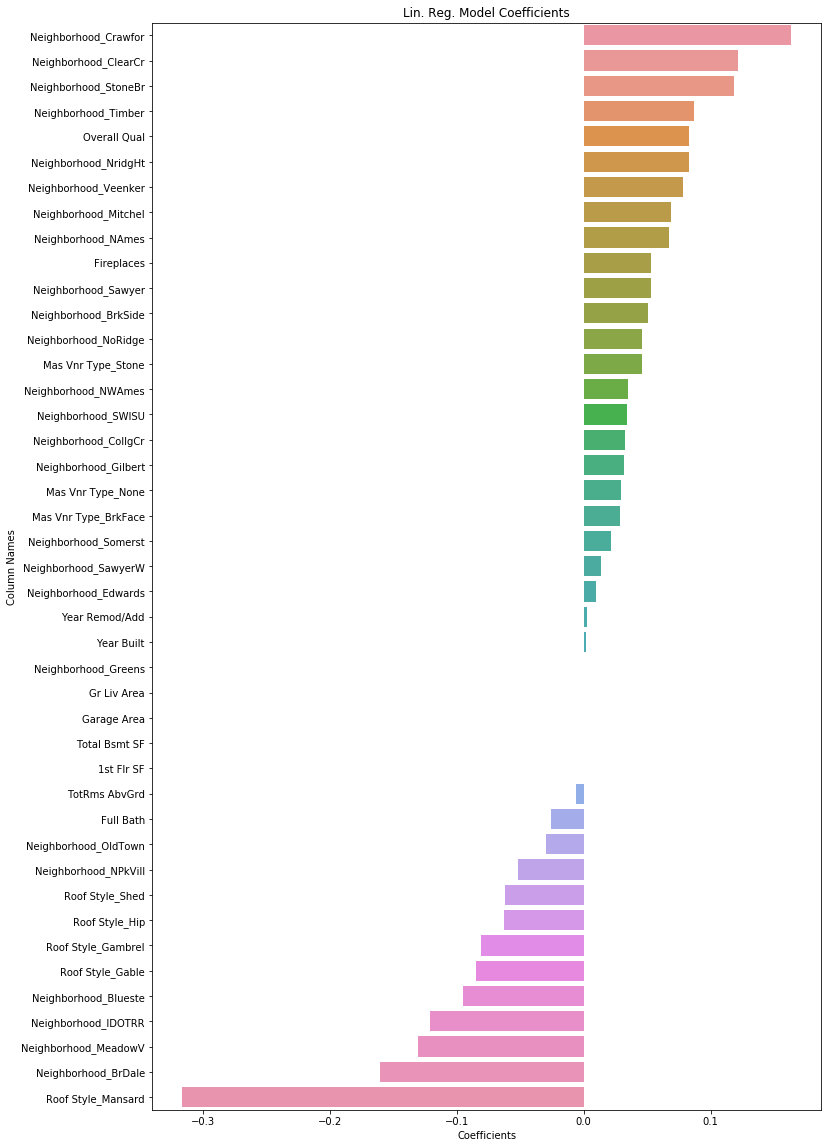

In [31]:
plt.figure(figsize = (12, 20))
plt.title('Lin. Reg. Model Coefficients')
sns.barplot(coef_df['coef'], coef_df['col_name']);
plt.xlabel('Coefficients')
plt.ylabel('Column Names');

In [32]:
neighborhood_coefs = coef_df[(coef_df['col_name'].str.contains('Neigh'))]

In [33]:
pos_diff_ns = neighborhood_coefs[neighborhood_coefs['coef'] >= 0]
neg_dif_ns = neighborhood_coefs[neighborhood_coefs['coef'] <= 0]

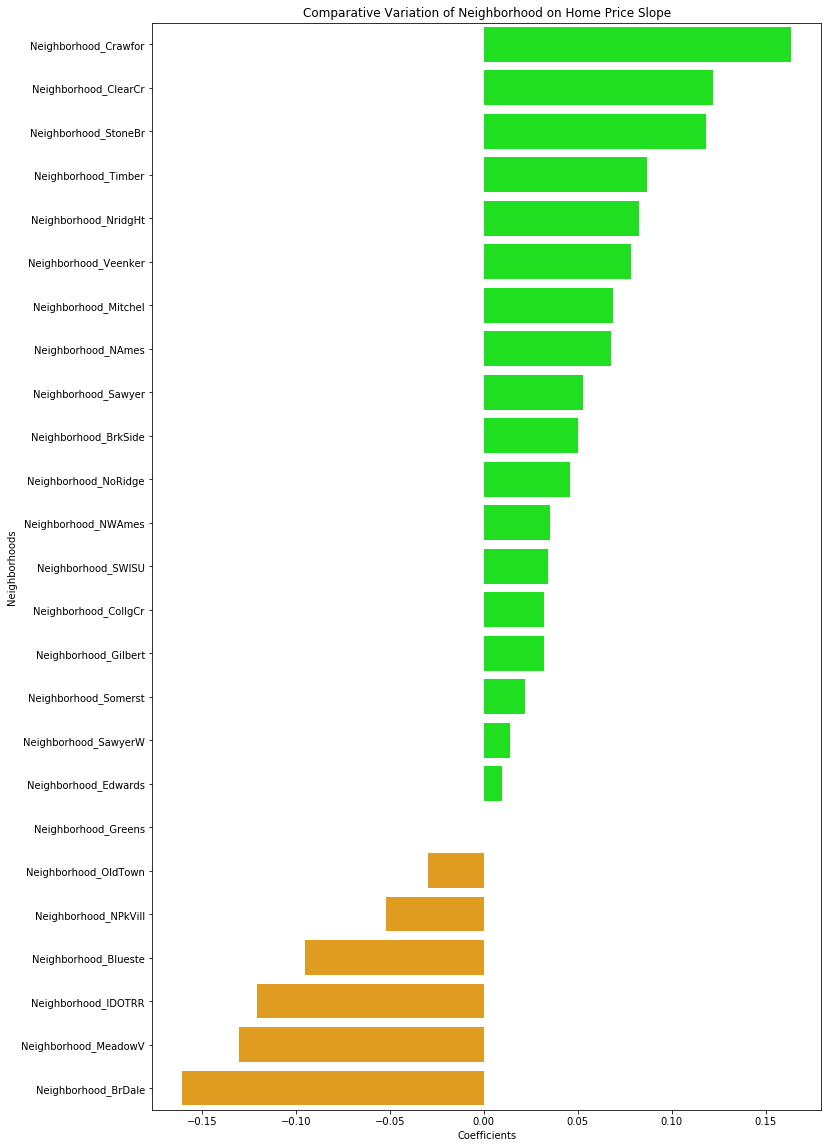

In [34]:
plt.figure(figsize = (12, 20))
plt.title('Comparative Variation of Neighborhood on Home Price Slope')
sns.barplot(pos_diff_ns['coef'], neighborhood_coefs['col_name'], color = 'lime')
sns.barplot(neg_dif_ns['coef'], neighborhood_coefs['col_name'], color = 'orange')
plt.xlabel('Coefficients')
plt.ylabel('Neighborhoods');

## Prep for Submission to Kaggle

In [35]:
kaggle_test.head(1)

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
PID,,,,,,,,,,,,,,,,,,,,,
902301120,2658,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD


In [37]:
kaggle_test = pd.get_dummies(kaggle_test, columns = ["Neighborhood",
                                   "Roof Style",
                                   'Mas Vnr Type'],
                    drop_first= True)

In [38]:
explanatory_vars = df.drop(columns = ['BsmtFin SF 1', 'Screen Porch',
                                      'Enclosed Porch', 'Kitchen AbvGr', 'Lot Frontage',
                                      'Id', 'Overall Cond', 'Mas Vnr Area',
                                      'Paved Drive', 'Sale Type', 'MS Zoning', 
                                      'Functional', 'Heating QC', 'House Style', 
                                      'Lot Frontage', 'MS SubClass', 'Bsmt Half Bath',
                                      'Low Qual Fin SF', 'Yr Sold', 'Misc Val', 
                                      'BsmtFin SF 2', 'Pool Area', 'Mo Sold', '3Ssn Porch', 
                                      'Bedroom AbvGr', 'Bsmt Unf SF', '2nd Flr SF',
                                      'Half Bath', 'Bsmt Full Bath', "Lot Area",
                                      'Wood Deck SF', 'Open Porch SF', 'Street',
                                      'Alley', 'Lot Shape', 'Land Contour',
                                      'Utilities', 'Lot Config', 'Land Slope',
                                      'Condition 1', 'Condition 2', 'Garage Cars',
                                      'Bldg Type', 'House Style', 
                                      'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
                                      'Exter Qual', 'Exter Cond',
                                      'Foundation', 'Bsmt Qual', 'Bsmt Cond',
                                      'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2',
                                      'Heating', 'Electrical', 'Kitchen Qual', 
                                      "Fireplace Qu", 'Garage Type', 'Garage Finish',
                                      'Garage Qual', 'Garage Cond', 'Paved Drive',
                                      'Pool QC', 'Fence', 'Misc Feature', 
                                      'Central Air', 'Garage Yr Blt',
                                      'Neighborhood_Landmrk', 'Neighborhood_GrnHill',
                                      'SalePrice'
                                     ]).columns



In [39]:
lr.predict(kaggle_test[explanatory_vars])

array([11.80124851, 12.15228639, 12.16248104, 11.6541497 , 12.0898644 ,
       11.42490626, 11.62658067, 11.85992623, 12.22200969, 12.06128137,
       11.95565123, 11.61391323, 12.00414268, 12.65070286, 12.01273874,
       11.74669594, 11.88759102, 11.67230014, 12.20730858, 12.01604877,
       11.85694745, 11.70497473, 12.1948859 , 12.09696878, 12.14901688,
       11.68110297, 11.84174451, 11.6464068 , 11.81852205, 11.21872722,
       11.67450356, 11.39986145, 12.12566473, 11.93440171, 12.28754493,
       12.12244026, 11.69017631, 11.42604698, 11.63555231, 12.16912361,
       11.99882098, 12.26122019, 11.94159218, 11.9619853 , 12.32371655,
       11.57199033, 12.30143282, 11.61639572, 11.75941523, 11.70408019,
       11.53361929, 12.0811265 , 12.51092704, 11.61526885, 11.54040717,
       11.93856879, 11.9274656 , 11.94517425, 12.03427201, 12.36731783,
       12.65264705, 11.66374488, 11.93429811, 12.0621952 , 12.00110891,
       12.69896565, 11.53461521, 12.24903873, 11.32955824, 11.95

In [40]:
kaggle_preds = np.exp(lr.predict(kaggle_test[explanatory_vars]))

In [41]:
submission = pd.DataFrame({
        'Id' : kaggle_test['Id'],
        'SalePrice' : kaggle_preds
})

In [42]:
submission.shape

(878, 2)

In [43]:
submission.to_csv('submission/july 9th.csv', index = False)

Model 1- 38,384.44 - Baseline model

Model 2- 38,323.96 - 2 more features added, minimal improvement

Model 3- 34,117.42- all numeric non-colinear features added

Model 4- 97,370,844.85- added all categorical variables-- this is too much, let's walk em back

Model 5- 32,408.6- reduced categorical colums to only look at:
     - "Neighborhood", 
     - "Roof Style", 
     - 'Mas Vnr Type'
    
Model 6- 23,255.24 Noted residuals were in a distinct pattern, switched to log of sale price in prediction, exponential of prediction.

Model 7- spent some time looking at VIF factors and eliminating factors
    that are likely to throw the model off.


Model 8- 23,185.29  This will be my production model.  